# Project
Course: Business Intelligence

Authors:
* Daniel Stevens, h17daste@du.se
* Omar Omran, h24omaom@du.se

## Imports

In [1]:
# math and dataframes
import numpy as np
import pandas as pd
# plots
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
# regex
import re
# BERT-related stuff
import torch # NOTE: this requires typing_extensions 4.11.0, as far as I can tell
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TextClassificationPipeline
from scipy.special import softmax
# Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
# Decision trees
from sklearn import tree

c:\Users\gemin\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


### Datasets

In [2]:
path_home = "" # leave blank if csv files are in current working directory
path_headline = path_home+"headlines.csv"
path_stocks = path_home+"sp500_stocks.csv"

In [3]:
# Load these two in separate cells since it can take a while to process
df_headlines = pd.read_csv(path_headline)

In [4]:
df_headlines.head()

,Date,Publication,Headline,URL
0,20070101,New York Times,Rush to Hang Hussein Was Questioned,http://www.nytimes.com/2007/01/01/world/middle...
1,20070101,New York Times,"News Analysis: For Sunnis, Dictators End Is O...",http://www.nytimes.com/2007/01/01/world/middle...
2,20070101,New York Times,Hard Choices Over Video,http://www.nytimes.com/2007/01/01/world/middle...
3,20070101,New York Times,States Take Lead on Ethics Rules for Lawmakers,http://www.nytimes.com/2007/01/01/us/01ethics....
4,20070101,New York Times,"Spitzer Arrives With Mandate, but Faces Challe...",http://www.nytimes.com/2007/01/01/nyregion/01e...


In [5]:
df_stocks = pd.read_csv(path_stocks)

In [6]:
df_stocks.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,MMM,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,MMM,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-06,MMM,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-07,MMM,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-08,MMM,NaN,NaN,NaN,NaN,NaN,NaN


## Cleaning datasets

### Dates

In [7]:
# convert date columns to datetime format
df_headlines['Date'] = pd.to_datetime(
    df_headlines['Date'].astype(str),
    format='%Y%m%d',
    errors='coerce'
)
df_stocks['Date'] = pd.to_datetime(
    df_stocks['Date'].astype(str),
    errors='coerce'
)

In [8]:
# remove rows with invalid dates
df_headlines = df_headlines.dropna(subset=['Date'])
df_stocks    = df_stocks.dropna(subset=['Date'])

# keep only rows between 2010 and 2022
df_headlines = df_headlines[df_headlines['Date'] >= '2010-01-01']
df_stocks    = df_stocks[(df_stocks['Date'] >= '2010-01-01') & (df_stocks['Date'] < '2023-01-01')]

### Lowercase

In [9]:
df_headlines['Headline'] = df_headlines['Headline'].str.lower()

In [10]:
df_headlines['Headline'].head()

574035      suicide bomber attacks sports event in pakistan
574036     iraqis angered as blackwater charges are dropped
574037    c.i.a. takes on bigger and riskier role on fro...
574038       afghans charge 2nd case of civilian casualties
574039    for ailing illegal immigrants, no relief back ...
Name: Headline, dtype: object

### Stock values

In [11]:
# remove symbols that have no price data at all
price_cols  = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
all_nan     = df_stocks[price_cols].isna().all(axis=1)
fully_blank = all_nan.groupby(df_stocks['Symbol']).all()
good_syms   = fully_blank.index[~fully_blank]
df_stocks   = df_stocks[df_stocks['Symbol'].isin(good_syms)]

# keep only symbols that have at least 90% of trading days
total_days = df_stocks['Date'].nunique()
min_days   = 0.9 * total_days
counts     = df_stocks.groupby('Symbol')['Date'].nunique()
keep_syms  = counts[counts >= min_days].index
df_stocks  = df_stocks[df_stocks['Symbol'].isin(keep_syms)]

### Miscellanea

In [12]:
# drop NA headlines
df_headlines = df_headlines[df_headlines['Headline'].notna()]

In [13]:
# show data range and size
print("headlines:", df_headlines['Date'].min(), "→", df_headlines['Date'].max(),
      f"({df_headlines.shape[0]} rows)")
print("stocks   :", df_stocks['Date'].min(), "→", df_stocks['Date'].max(),
      f"({df_stocks['Symbol'].nunique()} symbols, {df_stocks.shape[0]} rows)")


headlines: 2010-01-01 00:00:00 → 2023-01-01 00:00:00 (3794428 rows)
stocks   : 2010-01-04 00:00:00 → 2022-12-30 00:00:00 (170 symbols, 556240 rows)


### Cut Down to One Company

Consider this a proof of concept. To run this for the entirety of the S&P 500, repeat this 500+ times with different keywords corresponding to your chosen companies.

You may also choose to omit this section entirely, and try to gauge whether the sentiment of unfiltered news affects the stock price. However, note that the news dataset has millions of headlines, and running sentiment analysis on them can take a *very* long time.

In [14]:
# Keywords that count as a match for our company.
# If any are within the headline, it's a match.
# Note that these must be lowercase.
symbols = ["NVDA"]
keywords = ["nvidia"]

In [15]:
# Combine stock tickers, then filter rows by that
stock_pattern = r'\b(?:' + '|'.join(map(re.escape, symbols)) + r')\b'
df_stocks = df_stocks[df_stocks['Symbol'].str.contains(stock_pattern, na=False, regex=True)]
df_stocks

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
1307496,2010-01-04,NVDA,0.423923,0.46225,0.4655,0.45275,0.46275,800204000.0
1307497,2010-01-05,NVDA,0.430113,0.46900,0.4740,0.46050,0.46050,728648000.0
1307498,2010-01-06,NVDA,0.432864,0.47200,0.4730,0.46425,0.46875,649168000.0
1307499,2010-01-07,NVDA,0.424381,0.46275,0.4715,0.45925,0.46950,547792000.0
1307500,2010-01-08,NVDA,0.425298,0.46375,0.4670,0.45625,0.45900,478168000.0
...,...,...,...,...,...,...,...,...
1310763,2022-12-23,NVDA,15.194948,15.20600,15.3390,14.88300,15.19600,349326000.0
1310764,2022-12-27,NVDA,14.110736,14.12100,15.1000,14.05600,15.07400,464902000.0
1310765,2022-12-28,NVDA,14.025799,14.03600,14.2620,13.88400,13.92700,351066000.0
1310766,2022-12-29,NVDA,14.592386,14.60300,14.6830,14.22700,14.40200,354923000.0


In [16]:
# Combine keywords as regex, then filter rows by that
headline_pattern = r'\b(?:' + '|'.join(map(re.escape, keywords)) + r')\b'
df_headlines = df_headlines[df_headlines['Headline'].str.contains(headline_pattern, na=False, regex=True)]
df_headlines

,Date,Publication,Headline,URL
955554,2011-05-30,New York Times,"as pc markets slow, nvidia aims at tablets",http://www.nytimes.com/2011/05/30/technology/3...
1180550,2012-02-15,CNBC,nvidia pullback presents opportunity,http://www.cnbc.com/id/46403791
1259084,2012-05-15,BBC,nvidia aims for fastest computer,http://www.bbc.co.uk/news/18033970
1408494,2012-10-29,Washington Post,oak ridge and nvidia unveil titan,http://www.washingtonpost.com/blogs/innovation...
1586118,2013-05-15,BBC,nvidia details shield console launch,http://www.bbc.com/news/technology-22540218
...,...,...,...,...
4369081,2022-11-16,CNBC,nvidia revenue falls 17% but data center growt...,https://www.cnbc.com/2022/11/16/nvidia-nvda-ea...
4369118,2022-11-16,CNBC,stocks making the biggest moves after hours: c...,https://www.cnbc.com/2022/11/16/stocks-making-...
4380439,2022-12-01,CNBC,nvidia and more: cnbc's 'halftime report' trad...,https://www.cnbc.com/2022/12/01/nvidia-and-mor...
4380466,2022-12-01,CNBC,"bhp, nvidia and more: cnbc's 'halftime report'...",https://www.cnbc.com/2022/12/01/nvidia-and-mor...


Since we've now got a much smaller dataset, we can drop even more dates:

In [17]:
# keep only headlines within the range of the stocks
stocks_start = df_stocks['Date'].min()
stocks_stop = df_stocks['Date'].max()

df_headlines = df_headlines[(df_headlines['Date'] >= stocks_start) & (df_headlines['Date'] <= stocks_stop)]

### Reset index

In [18]:
# reset index
df_headlines.reset_index(drop=True, inplace=True)
df_stocks.reset_index(drop=True, inplace=True)

## Sentiment Analysis

In [19]:
# Load model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [20]:
# Create pipeline
sentiment_pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None, framework='pt')

# Define sentiment labels
labels = [
    "negative",
    "neutral",
    "positive"
    ]

# Function to get highest-scoring label
def analyze_sentiment(text):
    # Preprocess text
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=500)
    with torch.no_grad():
        output = model(**encoded_input)
    
    scores = output.logits[0].numpy()
    scores = softmax(scores)
    
    sentiment = labels[np.argmax(scores)]
        
    return sentiment

# Apply to headlines
df_headlines['Sentiment'] = df_headlines['Headline'].apply(
    lambda x: pd.Series(analyze_sentiment(x))
)
df_headlines.head()

,Date,Publication,Headline,URL,Sentiment
0,2011-05-30,New York Times,"as pc markets slow, nvidia aims at tablets",http://www.nytimes.com/2011/05/30/technology/3...,neutral
1,2012-02-15,CNBC,nvidia pullback presents opportunity,http://www.cnbc.com/id/46403791,positive
2,2012-05-15,BBC,nvidia aims for fastest computer,http://www.bbc.co.uk/news/18033970,neutral
3,2012-10-29,Washington Post,oak ridge and nvidia unveil titan,http://www.washingtonpost.com/blogs/innovation...,neutral
4,2013-05-15,BBC,nvidia details shield console launch,http://www.bbc.com/news/technology-22540218,neutral


In [21]:
df_headlines.to_csv('headline_sentiments.csv', index=False)
print("File written.")

File written.


In [22]:
# Convert sentiment labels to numeric values
sentiment_map = {
    'negative': -1,
    'neutral': 0,
    'positive': 1,
}
df_headlines['SentimentScore'] = df_headlines['Sentiment'].map(sentiment_map)

In [23]:
# create dataframe with sentiment mean
daily_sentiment = df_headlines.groupby('Date').agg({'SentimentScore':'mean',})

In [24]:
# create dataframe with sentiment counts
daily_counts = df_headlines.groupby(['Date','Sentiment']).size().unstack(fill_value=0)

In [25]:
# create dataframe of Net Promoter Score-esque ratings
def compute_daily_nps(group):
    total = len(group)
    promoters = (group=='positive').sum()
    detractors = (group=='negative').sum()
    return 100 * (promoters - detractors) / total

daily_nps = df_headlines.groupby('Date')['Sentiment'].apply(compute_daily_nps)
daily_nps.head()

Date
2011-05-30      0.0
2012-02-15    100.0
2012-05-15      0.0
2012-10-29      0.0
2013-05-15      0.0
Name: Sentiment, dtype: float64

c:\Users\gemin\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


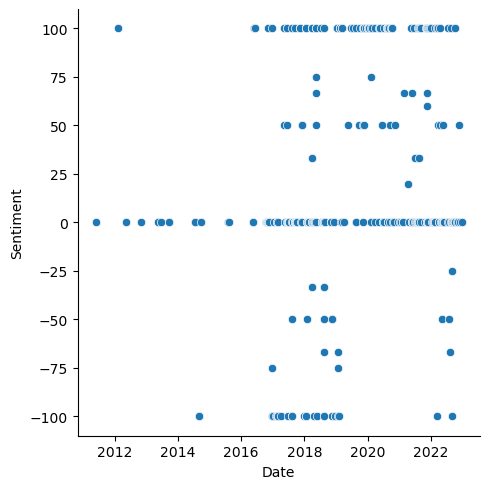

In [26]:
sns.relplot(daily_nps)

## Adding Columns to the Stocks Dataframe

In [27]:
# NOTE: This code only works properly if you have filtered for single stock symbols.
# If you are working with multiple stocks, you will have to adjust this code.
# Note also that the dataset we are working with is sorted by date.
df_stocks['PrevClose'] = df_stocks['Close'].shift(1)
df_stocks['NextOpen'] = df_stocks['Open'].shift(-1)

In [28]:
# Add percentile change columns
# Morning gains/losses, catch premarket news
df_stocks['Open_vs_PrevClose'] = (df_stocks['Open'] - df_stocks['PrevClose']) / df_stocks['PrevClose']
# Daily gain/loss
df_stocks['Close_vs_Open'] = (df_stocks['Close'] - df_stocks['Open']) / df_stocks['Open']
# Post-market gains/losses
df_stocks['NextOpen_vs_Close'] = (df_stocks['NextOpen'] - df_stocks['Close']) / df_stocks['Close']

In [29]:
df_stocks.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,PrevClose,NextOpen,Open_vs_PrevClose,Close_vs_Open,NextOpen_vs_Close
0,2010-01-04,NVDA,0.423923,0.46225,0.4655,0.45275,0.46275,800204000.0,NaN,0.46050,NaN,-0.001080,-0.003786
1,2010-01-05,NVDA,0.430113,0.46900,0.4740,0.46050,0.46050,728648000.0,0.46225,0.46875,-0.003786,0.018458,-0.000533
2,2010-01-06,NVDA,0.432864,0.47200,0.4730,0.46425,0.46875,649168000.0,0.46900,0.46950,-0.000533,0.006933,-0.005297
3,2010-01-07,NVDA,0.424381,0.46275,0.4715,0.45925,0.46950,547792000.0,0.47200,0.45900,-0.005297,-0.014377,-0.008104
4,2010-01-08,NVDA,0.425298,0.46375,0.4670,0.45625,0.45900,478168000.0,0.46275,0.46625,-0.008104,0.010349,0.005391


In [30]:
df_stocks.isna().describe()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,PrevClose,NextOpen,Open_vs_PrevClose,Close_vs_Open,NextOpen_vs_Close
count,3272,3272,3272,3272,3272,3272,3272,3272,3272,3272,3272,3272,3272
unique,1,1,1,1,1,1,1,1,2,2,2,1,2
top,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,3272,3272,3272,3272,3272,3272,3272,3272,3271,3271,3271,3272,3271


## Combining Datasets

In [31]:
# Combine the dataframes - note that by doing an inner merge we skip days that don't have news as well as days the market is closed (mainly weekends).
df_merged = pd.merge(daily_sentiment, df_stocks[['Date','Open_vs_PrevClose','Close_vs_Open','NextOpen_vs_Close']], on='Date', how='inner')

In [32]:
df_merged.isna().describe()

,Date,SentimentScore,Open_vs_PrevClose,Close_vs_Open,NextOpen_vs_Close
count,232,232,232,232,232
unique,1,1,1,1,1
top,False,False,False,False,False
freq,232,232,232,232,232


In [33]:
df_merged.head()

,Date,SentimentScore,Open_vs_PrevClose,Close_vs_Open,NextOpen_vs_Close
0,2012-02-15,1.0,0.009237,-0.013423,-0.068646
1,2012-05-15,0.0,0.000000,-0.009901,0.001539
2,2013-05-15,0.0,-0.004844,0.022253,-0.001361
3,2013-05-20,0.0,-0.004035,0.002026,0.000674
4,2013-06-26,0.0,0.011252,-0.016690,0.002829


In [34]:
df_merged.describe()

,Date,SentimentScore,Open_vs_PrevClose,Close_vs_Open,NextOpen_vs_Close
count,232,232.000000,232.000000,232.000000,232.000000
mean,2019-06-26 01:02:04.137931008,0.222917,0.002192,0.001427,0.001456
min,2012-02-15 00:00:00,-1.000000,-0.193043,-0.105631,-0.193043
25%,2017-11-09 18:00:00,0.000000,-0.006726,-0.013428,-0.008267
50%,2019-06-01 12:00:00,0.000000,0.002604,0.000804,0.001435
75%,2021-08-07 12:00:00,1.000000,0.012288,0.014941,0.010311
max,2022-12-23 00:00:00,1.000000,0.110258,0.113183,0.173233
std,NaN,0.600187,0.028176,0.030194,0.028037


## Data Analysis

### Correlation

<Axes: >

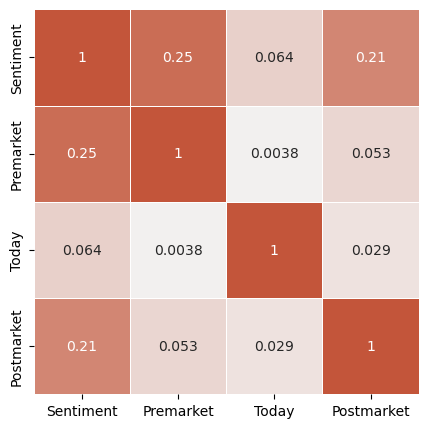

In [35]:
## Correlation plot
corr = df_merged[['SentimentScore','Open_vs_PrevClose','Close_vs_Open','NextOpen_vs_Close']].corr()

# Keywords
labels = ["Sentiment","Premarket","Today","Postmarket"]

# create mask for upper triangle
#mask = np.triu(np.ones_like(corr, dtype=bool))

# set up figure
f, ax = plt.subplots(figsize=(5,5))

# generate diverging colormap
cmap = sns.diverging_palette(230,20,as_cmap=True)

# draw heatmap
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar=False, annot=True, xticklabels=labels, yticklabels=labels)

### Scatterplot

<Axes: xlabel='SentimentScore', ylabel='Open_vs_PrevClose'>

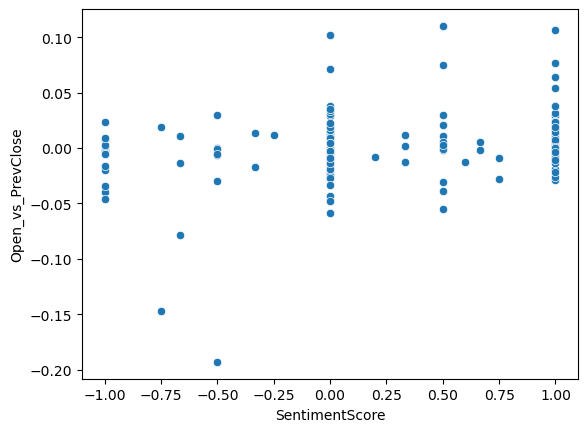

In [36]:
# Scatterplot
sns.scatterplot(data=df_merged, x="SentimentScore", y="Open_vs_PrevClose")

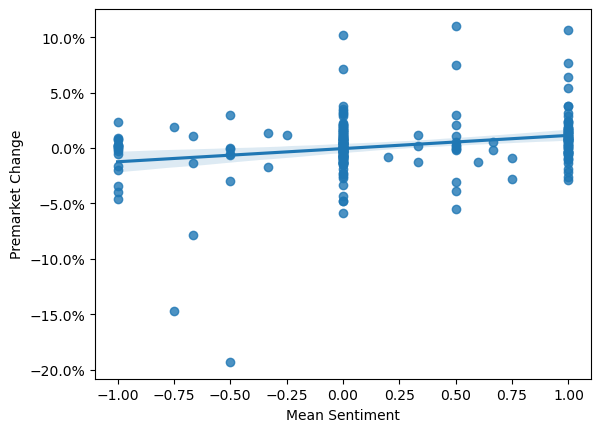

In [37]:
p = sns.regplot(x=df_merged['SentimentScore'], y=df_merged['Open_vs_PrevClose'], data=df_merged)
p.set(xlabel="Mean Sentiment", ylabel="Premarket Change")
p.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

### Classification

In [38]:
# Create binary labels
df_merged['SentimentScore_Label'] = (df_merged['SentimentScore']>0).astype(int)
df_merged['Open_vs_PrevClose_Label'] = (df_merged['Open_vs_PrevClose']>0).astype(int)
df_merged['Close_vs_Open_Label'] = (df_merged['Close_vs_Open']>0).astype(int)
df_merged['NextOpen_vs_Close_Label'] = (df_merged['NextOpen_vs_Close']>0).astype(int)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df_merged[['SentimentScore','Open_vs_PrevClose','Close_vs_Open']], df_merged['Open_vs_PrevClose_Label'], test_size=0.3, random_state=0)

In [40]:
clf = LogisticRegression(random_state=0).fit(X_train,y_train)

In [41]:
clf.score(X_test,y_test)

0.6285714285714286

In [42]:
# Confusion matrix
y_pred = clf.predict(X_test)
y_true = y_test
cmatrix = confusion_matrix(y_true,y_pred,labels=[0,1])

In [43]:
# Extract true negative, false positive, false negative, true positive
tn, fp, fn, tp = cmatrix.ravel()
print("TN:",tn,"FP:", fp,"FN:", fn,"TP:", tp)
print(f"Accurate predictions: {100*(tn+tp)/(tn+fp+fn+tp):.2f}%")
print(f"F1-score: {f1_score(y_true,y_pred)}")

TN: 3 FP: 22 FN: 4 TP: 41
Accurate predictions: 62.86%
F1-score: 0.7592592592592592


<Axes: >

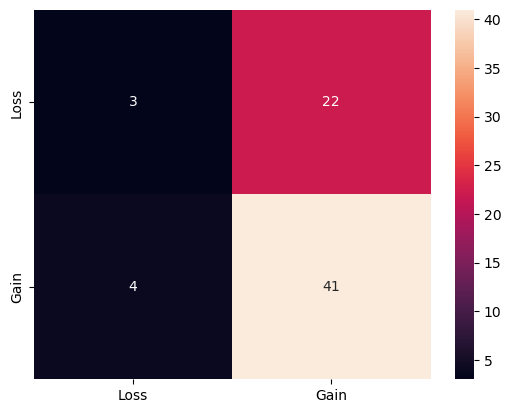

In [44]:
labels = ["Loss","Gain"]
sns.heatmap(cmatrix, annot=True, xticklabels=labels, yticklabels=labels)

### Decision Tree

In [45]:
X = df_merged[['SentimentScore','Open_vs_PrevClose','Close_vs_Open']]
Y = df_merged['NextOpen_vs_Close_Label']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)


[Text(0.5, 0.9, 'Today <= -0.076\ngini = 0.494\nsamples = 162\nvalue = [72, 90]'),
 Text(0.3333333333333333, 0.7, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(0.6666666666666666, 0.7, 'Today <= 0.065\ngini = 0.491\nsamples = 159\nvalue = [69, 90]'),
 Text(0.5, 0.5, 'Today <= 0.052\ngini = 0.494\nsamples = 155\nvalue = [69, 86]'),
 Text(0.3333333333333333, 0.3, 'Premarket <= -0.047\ngini = 0.491\nsamples = 152\nvalue = [66, 86]'),
 Text(0.16666666666666666, 0.1, '\n  (...)  \n'),
 Text(0.5, 0.1, '\n  (...)  \n'),
 Text(0.6666666666666666, 0.3, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(0.8333333333333334, 0.5, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]')]

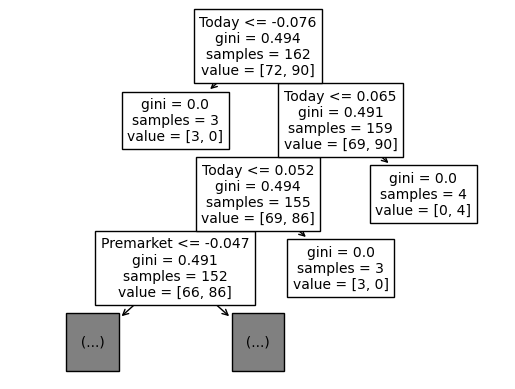

In [46]:
feature_names = ["Sentiment", "Premarket", "Today"]
tree.plot_tree(clf, feature_names=feature_names, max_depth=3)

In [47]:
y_pred = clf.predict(X_test)
y_true = y_test
cmatrix = confusion_matrix(y_true,y_pred,labels=[0,1])

In [48]:
# Extract true negative, false positive, false negative, true positive
tn, fp, fn, tp = cmatrix.ravel()
print("TN:",tn,"FP:", fp,"FN:", fn,"TP:", tp)
print(f"Accurate predictions: {100*(tn+tp)/(tn+fp+fn+tp):.2f}%")
print(f"F1-score: {f1_score(y_true,y_pred)}")

TN: 15 FP: 17 FN: 12 TP: 26
Accurate predictions: 58.57%
F1-score: 0.6419753086419753


<Axes: >

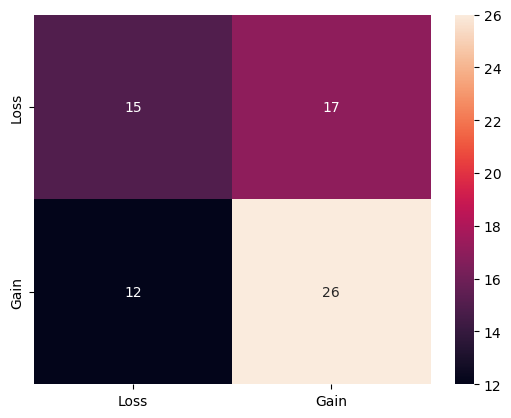

In [49]:
labels = ["Loss","Gain"]
sns.heatmap(cmatrix, annot=True, xticklabels=labels, yticklabels=labels)